### Experiment for Quant-UCB

#### Test for design of upper quantile

Finite arm setting (two arms):  

Arm one: normal distribution with mean 0.72 and variance 1:  
Mean 0.72 Median 0.72  

Arm two: [skewed normal distribution](https://en.wikipedia.org/wiki/Skew_normal_distribution) with skewness 4
Standard skewed normal distribution
$$f(x) = 2\phi(x)\Phi(\alpha x)$$
where $\phi(x)$ is the standard normal pdf, $\Phi(x)$ is the standard normal cdf.  
Mean 0.77 Median 0.67  

Plotting are given below.

#### Selection rule for quantile ucb

$$\text{action} = argmax \quad q_{\alpha_t}(\text{reward})$$
where $q_{\alpha_t}$ is the upper quantile. Some choices of $\alpha_t$ (n is the total number of iterations): 

Linear limit: $\alpha_t = 0.5 + t/(2n)$    
Square limit: $\alpha_t = 0.5 + t^2/(2n^2)$    
Log: $\alpha_t = log(t + 1)/n$        
Loge limit: $\alpha_t = 0.5 + log(t + 1)/(2n)$

#### Definition of the measurement

For multi-armed bandit problem, we usually define:  
best action: choosing the arm with the maximum expected cumulative reward.   
cumulative regret: cumulative reward of best action - cumulative reward of selected action

For quantile ucb, I show the cumulative regret for each upper quantile design vs number of iterations.
To compare, I also show the performance of the ucb1.
The regret is computed as the expected value of 50 experiments, where each experiment has 10000 iterations.

#### Things to discuss

1. How to design experiments? For example, why use skewed distribution here. What properties of quantile-ucb do we want to show according to that? 
2. How to define the best action? why expectation rather than median?
3. How to intepret the plotting results? 

#### Todos
1. Other possible quantile ucb selection rules.
2. CVaR ucb design
3. Compare with quantile ucb and CVaR
4. the case for continuous arms. 

In [1]:
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict
import math

### skew normal distribution

In [2]:
NUM_SAMPLES = 100000
SKEW_PARAMS = 4

def rand_skew_norm(fAlpha, fLocation, fScale):
    sigma = fAlpha / np.sqrt(1.0 + fAlpha**2) 

    afRN = np.random.randn(2)
    u0 = afRN[0]
    v = afRN[1]
    u1 = sigma*u0 + np.sqrt(1.0 -sigma**2) * v 

    if u0 >= 0:
        return u1*fScale + fLocation 
    return (-u1)*fScale + fLocation 

def randn_skew(N, skew=0.0):
    return [rand_skew_norm(skew, 0, 1) for x in range(N)]

### visualize the normal and skew normal distribution

For normal distribution:
mean: -0.002871, median: -0.000018
0.9918278475248815

For skewed normal distribution:
mean: -0.775638, median: -0.673306
-0.16788420979159752

For skewed normal distribution:
mean: 0.772325, median: 0.672960
1.3992765806220349


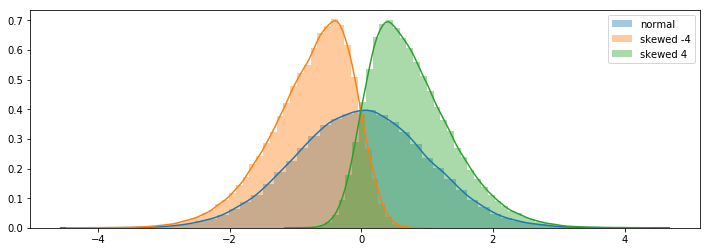

In [3]:
def quantile(data, alpha):
    '''
    return the alpha-quantile for given data samples
    '''
    data = np.sort(data)
    idx = int(len(data) * alpha) - 1
    return data[idx]

plt.subplots(figsize=(12,4))

# normal 
n = np.random.normal(0,1, NUM_SAMPLES)
print('For normal distribution:')
print('mean: %f, median: %f' % (np.mean(n), np.median(n)))
print(quantile(n, 0.84))

#for alpha_skew in SKEW_PARAMS:
p1 = randn_skew(NUM_SAMPLES, -4)
print()
print('For skewed normal distribution:')
print('mean: %f, median: %f' % (np.mean(p1), np.median(p1)))
print(quantile(p1, 0.84))

#for alpha_skew in SKEW_PARAMS:
p2 = randn_skew(NUM_SAMPLES, 4)
print()
print('For skewed normal distribution:')
print('mean: %f, median: %f' % (np.mean(p2), np.median(p2)))
print(quantile(p2, 0.84))

sns.distplot(n, label = 'normal')
sns.distplot(p1, label = 'skewed -4')
sns.distplot(p2, label = 'skewed 4')
plt.legend()

### visualize the simulated arm distribution

For normal distribution:
mean: 0.723934, median: 0.724050

For skewed normal distribution:
mean: 0.772325, median: 0.672960


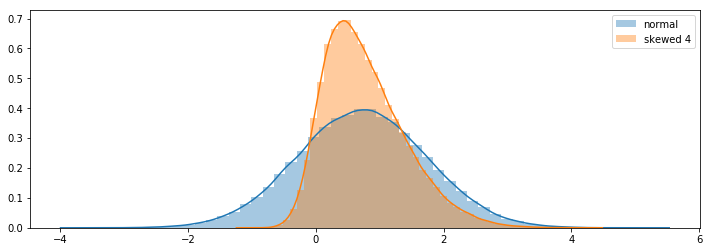

In [4]:
# carefully choose parameters to let skew normal have larger mean and smaller median

plt.subplots(figsize=(12,4))

# normal 
n = np.random.normal(0.72,1, NUM_SAMPLES)
print('For normal distribution:')
print('mean: %f, median: %f' % (np.mean(n), np.median(n)))

#for alpha_skew in SKEW_PARAMS:
p = randn_skew(NUM_SAMPLES, 4)
print()
print('For skewed normal distribution:')
print('mean: %f, median: %f' % (np.mean(p2), np.median(p2)))

sns.distplot(n, label = 'normal')
sns.distplot(p, label = 'skewed 4')
plt.legend()

In [5]:
# settings

num_exper = 1
num_rounds = 5000
loc = 0.72
scale = 1
alpha_skew = 4

In [6]:
def quantile(data, alpha):
    '''
    return the alpha-quantile for given data samples
    '''
    data = np.sort(data)
    idx = int(len(data) * alpha) - 1
    return data[idx]

def CVaR(data, a):
    '''
    return the alpha-CVaR for given data samples
    '''
    data = np.sort(data)
    # idx = int(data.shape[0] * a)
    idx = int(len(data) * a) - 1
    CVaR = np.mean(data[idx:])
    return CVaR

arm_name = ['normal', 'skewed']

def quant_ucb_with_expectation(num_rounds, loc, scale, alpha_skew, level):
    '''
    Quantile UCB experiment:
    selet the arm with the maximum upper quantile
    the design upper quantile is a function about 'num_rounds' and specified by 'level' function 
    
    Returns the cumulative regret list
    Cumulative regret is defined by the difference of the cumulative reward of the best action 
    (the action with the maximum expected reward) and the cumulative reward of the selected action.
    '''
    rewards = defaultdict(list)
    ucbs = defaultdict(list)
    
    # initialize empirical reward
    rewards['normal'].append(np.random.normal(loc, scale)) 
    rewards['skewed'].append(randn_skew(1, alpha_skew)[0])
    
    # define best action as skewed arm since it has larger expected value
    cumulativeReward = 0
    bestActionCumulativeReward = 0
    Regret_list = []
    selection = {}
    alpha = defaultdict(list)
    
    #for level in quantile_level_choice:
    for i in range(2, num_rounds):
        for arm in arm_name:
            alpha[arm].append(np.sqrt(np.log(i+1)/selection.get(arm, 1)))
            #ucbs[arm] = np.mean(rewards[arm]) + CVaR(rewards[arm], level(i, selection.get(arm, 1)))
            ucbs[arm] = CVaR(rewards[arm], level(i, selection.get(arm, 1)))
            print(arm, ': ', ucbs[arm])
        if ucbs['normal'] > ucbs['skewed']:
            theReward = np.random.normal(loc, scale, 1)[0]
            rewards['normal'].append(theReward)
            selection['normal'] = selection.get('normal', 1) + 1
            bestActionCumulativeReward += randn_skew(1, alpha_skew)[0]
            #bestActionCumulativeReward += theReward
        else:
            theReward = randn_skew(1, alpha_skew)[0]
            rewards['skewed'].append(theReward)
            selection['skewed'] = selection.get('skewed', 1) + 1
            bestActionCumulativeReward += theReward
            #bestActionCumulativeReward += np.random.normal(loc, scale, 1)[0]
        cumulativeReward += theReward
        regret = bestActionCumulativeReward - cumulativeReward
        Regret_list.append(regret)
            
    return Regret_list, selection, alpha

### QuantUCB with different upper quantile choices

In [7]:
# Report the how cumulative reward changed in terms of different alpha level design

Regret_dict = defaultdict(list)
selection_dict = defaultdict(list)

def loge(t, num_rounds):
    return np.log(t + 1)/num_rounds
def log2(t, num_rounds):
    return np.log2(t + 1)/num_rounds
def log10(t, num_rounds):
    return np.log10(t + 1)/num_rounds

def loge_limit(t, num_rounds):
    #return 0.5 + np.log(t + 1)/(num_rounds * 2)
    return np.log(t + 1)/(num_rounds * 2)
    #return 1 - np.log(t+1)/20
    
def loge_nj(t, n_selected):
    alpha = np.sqrt(np.log(t+1)/n_selected)
    if alpha >= 1:
        return 0.8
    #elif alpha > 0.1:
        #print('in %d iteration, alpha is %f', (t, alpha))
    #    return alpha
    #elif alpha < 0.1:
    #    return 0.1
    else: 
        return alpha

level_list = [loge_nj]
level_name = ['loge_nj']

for exper in range(num_exper):
    for i, level in enumerate(level_list):
        regret, selection, alpha = quant_ucb_with_expectation(num_rounds, loc, scale, alpha_skew, level)
        Regret_dict[level_name[i]].append(regret)
        #selection_dict[level_name[i]].append(selection)
        #Regret_list = quant_ucb(num_rounds, loc, scale, alpha_skew, level)

normal :  1.7000329932746383
skewed :  0.38597290925963545
normal :  1.3898610293519837
skewed :  0.38597290925963545
normal :  1.3898610293519837
skewed :  0.38597290925963545
normal :  1.4236995668210106
skewed :  0.38597290925963545
normal :  1.9570154451823825
skewed :  0.38597290925963545
normal :  1.7376838502441188
skewed :  0.38597290925963545
normal :  1.7536250430112414
skewed :  0.38597290925963545
normal :  1.7536250430112414
skewed :  0.38597290925963545
normal :  1.7768444866638893
skewed :  0.38597290925963545
normal :  1.7407375185850005
skewed :  0.38597290925963545
normal :  1.7407375185850005
skewed :  0.38597290925963545
normal :  1.730876991235442
skewed :  0.38597290925963545
normal :  1.816951951696642
skewed :  0.38597290925963545
normal :  1.908650425023076
skewed :  0.38597290925963545
normal :  1.8257542890637013
skewed :  0.38597290925963545
normal :  1.7225663454282836
skewed :  0.38597290925963545
normal :  1.7225663454282836
skewed :  0.38597290925963545


normal :  0.936830691711278
skewed :  0.38597290925963545
normal :  0.9371317656830243
skewed :  0.38597290925963545
normal :  0.9392109850876607
skewed :  0.38597290925963545
normal :  0.9401066577268206
skewed :  0.38597290925963545
normal :  0.9392630662808309
skewed :  0.38597290925963545
normal :  0.9430343942429897
skewed :  0.38597290925963545
normal :  0.9422718063806229
skewed :  0.38597290925963545
normal :  0.9414259337426475
skewed :  0.38597290925963545
normal :  0.9442894528059872
skewed :  0.38597290925963545
normal :  0.9456299674108273
skewed :  0.38597290925963545
normal :  0.9443729201566091
skewed :  0.38597290925963545
normal :  0.9450129997246707
skewed :  0.38597290925963545
normal :  0.9432945843309347
skewed :  0.38597290925963545
normal :  0.944945076942968
skewed :  0.38597290925963545
normal :  0.9467888345474821
skewed :  0.38597290925963545
normal :  0.9452241198258966
skewed :  0.38597290925963545
normal :  0.9463157168956416
skewed :  0.38597290925963545

normal :  0.9490912032006871
skewed :  0.38597290925963545
normal :  0.9490267965876682
skewed :  0.38597290925963545
normal :  0.9500741913347712
skewed :  0.38597290925963545
normal :  0.9487206014397777
skewed :  0.38597290925963545
normal :  0.9511101045093381
skewed :  0.38597290925963545
normal :  0.9511160510535109
skewed :  0.38597290925963545
normal :  0.9527255267328104
skewed :  0.38597290925963545
normal :  0.9542289539310354
skewed :  0.38597290925963545
normal :  0.9541964022751366
skewed :  0.38597290925963545
normal :  0.953566552982488
skewed :  0.38597290925963545
normal :  0.9525321373684189
skewed :  0.38597290925963545
normal :  0.9515795577224957
skewed :  0.38597290925963545
normal :  0.95070431167999
skewed :  0.38597290925963545
normal :  0.9486553116655967
skewed :  0.38597290925963545
normal :  0.946607053153597
skewed :  0.38597290925963545
normal :  0.9459058077362645
skewed :  0.38597290925963545
normal :  0.9458478461780678
skewed :  0.38597290925963545
n

skewed :  0.38597290925963545
normal :  0.9074636611920115
skewed :  0.38597290925963545
normal :  0.908166900236525
skewed :  0.38597290925963545
normal :  0.9100776298817023
skewed :  0.38597290925963545
normal :  0.9087297917097914
skewed :  0.38597290925963545
normal :  0.9094233371588358
skewed :  0.38597290925963545
normal :  0.9087387963793696
skewed :  0.38597290925963545
normal :  0.9088555957520421
skewed :  0.38597290925963545
normal :  0.908111525168899
skewed :  0.38597290925963545
normal :  0.9073123523778844
skewed :  0.38597290925963545
normal :  0.9067332100372361
skewed :  0.38597290925963545
normal :  0.9077491531841123
skewed :  0.38597290925963545
normal :  0.9089630642537553
skewed :  0.38597290925963545
normal :  0.9088027164795875
skewed :  0.38597290925963545
normal :  0.9086021847056158
skewed :  0.38597290925963545
normal :  0.9080526684447442
skewed :  0.38597290925963545
normal :  0.9076747737888047
skewed :  0.38597290925963545
normal :  0.9090899999784813

skewed :  0.38597290925963545
normal :  0.8857938672901474
skewed :  0.38597290925963545
normal :  0.88765880886395
skewed :  0.38597290925963545
normal :  0.8869591198786565
skewed :  0.38597290925963545
normal :  0.8878938736660578
skewed :  0.38597290925963545
normal :  0.887359147282985
skewed :  0.38597290925963545
normal :  0.8865843229075235
skewed :  0.38597290925963545
normal :  0.8866962424205949
skewed :  0.38597290925963545
normal :  0.8871243827547831
skewed :  0.38597290925963545
normal :  0.8867717018535692
skewed :  0.38597290925963545
normal :  0.886516825131879
skewed :  0.38597290925963545
normal :  0.8854806832414368
skewed :  0.38597290925963545
normal :  0.8847479681318569
skewed :  0.38597290925963545
normal :  0.884545836749072
skewed :  0.38597290925963545
normal :  0.8842224051869836
skewed :  0.38597290925963545
normal :  0.8835525091802285
skewed :  0.38597290925963545
normal :  0.8825120821913233
skewed :  0.38597290925963545
normal :  0.8837738069160889
sk

normal :  0.8529095960694898
skewed :  0.38597290925963545
normal :  0.8526625129613442
skewed :  0.38597290925963545
normal :  0.8522162953496455
skewed :  0.38597290925963545
normal :  0.8520651047580186
skewed :  0.38597290925963545
normal :  0.8517814513839913
skewed :  0.38597290925963545
normal :  0.8516979082080569
skewed :  0.38597290925963545
normal :  0.8513118655956313
skewed :  0.38597290925963545
normal :  0.8512717800674866
skewed :  0.38597290925963545
normal :  0.8512554413034777
skewed :  0.38597290925963545
normal :  0.8517435410603654
skewed :  0.38597290925963545
normal :  0.8520570737827936
skewed :  0.38597290925963545
normal :  0.8515614323620408
skewed :  0.38597290925963545
normal :  0.8521458864039559
skewed :  0.38597290925963545
normal :  0.85188944890032
skewed :  0.38597290925963545
normal :  0.8523606324257096
skewed :  0.38597290925963545
normal :  0.8515135385281379
skewed :  0.38597290925963545
normal :  0.8509867307940944
skewed :  0.38597290925963545

normal :  0.8438351614391896
skewed :  0.38597290925963545
normal :  0.8447064598029507
skewed :  0.38597290925963545
normal :  0.8448891545893621
skewed :  0.38597290925963545
normal :  0.8448674001530293
skewed :  0.38597290925963545
normal :  0.8441309181691852
skewed :  0.38597290925963545
normal :  0.8444254279150695
skewed :  0.38597290925963545
normal :  0.8439916139118732
skewed :  0.38597290925963545
normal :  0.8438213494353618
skewed :  0.38597290925963545
normal :  0.8441362509121844
skewed :  0.38597290925963545
normal :  0.8445225589193014
skewed :  0.38597290925963545
normal :  0.8438223310317629
skewed :  0.38597290925963545
normal :  0.8440893661648247
skewed :  0.38597290925963545
normal :  0.8442879235704096
skewed :  0.38597290925963545
normal :  0.8447050970381149
skewed :  0.38597290925963545
normal :  0.844322985887167
skewed :  0.38597290925963545
normal :  0.8442678333894387
skewed :  0.38597290925963545
normal :  0.8443656206441721
skewed :  0.3859729092596354

normal :  0.8355117241018399
skewed :  0.38597290925963545
normal :  0.8350009712501549
skewed :  0.38597290925963545
normal :  0.835707048826754
skewed :  0.38597290925963545
normal :  0.8356360494780752
skewed :  0.38597290925963545
normal :  0.8354502050481223
skewed :  0.38597290925963545
normal :  0.83547319342672
skewed :  0.38597290925963545
normal :  0.8357639473150633
skewed :  0.38597290925963545
normal :  0.836134420749545
skewed :  0.38597290925963545
normal :  0.836632060271447
skewed :  0.38597290925963545
normal :  0.8369382903124463
skewed :  0.38597290925963545
normal :  0.8362958552916316
skewed :  0.38597290925963545
normal :  0.8369460735666275
skewed :  0.38597290925963545
normal :  0.8371470113541839
skewed :  0.38597290925963545
normal :  0.8367291985557658
skewed :  0.38597290925963545
normal :  0.8367071903141833
skewed :  0.38597290925963545
normal :  0.8363251243803126
skewed :  0.38597290925963545
normal :  0.8360517837233251
skewed :  0.38597290925963545
no

normal :  0.8306564289997832
skewed :  0.38597290925963545
normal :  0.8309868642762381
skewed :  0.38597290925963545
normal :  0.8305505818230065
skewed :  0.38597290925963545
normal :  0.8304579329667755
skewed :  0.38597290925963545
normal :  0.830579264571786
skewed :  0.38597290925963545
normal :  0.8309943786118886
skewed :  0.38597290925963545
normal :  0.8308381037240051
skewed :  0.38597290925963545
normal :  0.830965719260903
skewed :  0.38597290925963545
normal :  0.8307153080637559
skewed :  0.38597290925963545
normal :  0.8305821966289082
skewed :  0.38597290925963545
normal :  0.8302486919015986
skewed :  0.38597290925963545
normal :  0.830392112735435
skewed :  0.38597290925963545
normal :  0.8306242453447116
skewed :  0.38597290925963545
normal :  0.8306860630734303
skewed :  0.38597290925963545
normal :  0.8304113836125732
skewed :  0.38597290925963545
normal :  0.8300933585916038
skewed :  0.38597290925963545
normal :  0.829800774226479
skewed :  0.38597290925963545
n

normal :  0.8319793788990612
skewed :  0.38597290925963545
normal :  0.8316660661206485
skewed :  0.38597290925963545
normal :  0.8318159331102669
skewed :  0.38597290925963545
normal :  0.8317224664122553
skewed :  0.38597290925963545
normal :  0.831418069802114
skewed :  0.38597290925963545
normal :  0.8312647893677861
skewed :  0.38597290925963545
normal :  0.8311221654800894
skewed :  0.38597290925963545
normal :  0.830836398481565
skewed :  0.38597290925963545
normal :  0.8310970122453081
skewed :  0.38597290925963545
normal :  0.8308594435332229
skewed :  0.38597290925963545
normal :  0.8304103696387699
skewed :  0.38597290925963545
normal :  0.8306885554374883
skewed :  0.38597290925963545
normal :  0.8309276201198186
skewed :  0.38597290925963545
normal :  0.8311003761921328
skewed :  0.38597290925963545
normal :  0.8317456220429148
skewed :  0.38597290925963545
normal :  0.8315688129582668
skewed :  0.38597290925963545
normal :  0.831097327712045
skewed :  0.38597290925963545


normal :  0.8208320575372877
skewed :  0.38597290925963545
normal :  0.8210570336612409
skewed :  0.38597290925963545
normal :  0.8212357750835345
skewed :  0.38597290925963545
normal :  0.8211330925556247
skewed :  0.38597290925963545
normal :  0.8213806540759189
skewed :  0.38597290925963545
normal :  0.8216327189542222
skewed :  0.38597290925963545
normal :  0.8214075095885153
skewed :  0.38597290925963545
normal :  0.8213417573050211
skewed :  0.38597290925963545
normal :  0.8216775150636377
skewed :  0.38597290925963545
normal :  0.8215112654031077
skewed :  0.38597290925963545
normal :  0.8216674583973268
skewed :  0.38597290925963545
normal :  0.8219926572156244
skewed :  0.38597290925963545
normal :  0.8220126025101472
skewed :  0.38597290925963545
normal :  0.8223522235750814
skewed :  0.38597290925963545
normal :  0.8219900581983721
skewed :  0.38597290925963545
normal :  0.8216368329023621
skewed :  0.38597290925963545
normal :  0.8214338729317125
skewed :  0.385972909259635

normal :  0.8216620684652624
skewed :  0.38597290925963545
normal :  0.8212496141632383
skewed :  0.38597290925963545
normal :  0.8211545701844053
skewed :  0.38597290925963545
normal :  0.8207749882751505
skewed :  0.38597290925963545
normal :  0.8209094515328775
skewed :  0.38597290925963545
normal :  0.8204278365889754
skewed :  0.38597290925963545
normal :  0.820412417971282
skewed :  0.38597290925963545
normal :  0.8205486004118104
skewed :  0.38597290925963545
normal :  0.8203235487042297
skewed :  0.38597290925963545
normal :  0.8202259592668427
skewed :  0.38597290925963545
normal :  0.8204674344542104
skewed :  0.38597290925963545
normal :  0.8200215103402781
skewed :  0.38597290925963545
normal :  0.8202224606279671
skewed :  0.38597290925963545
normal :  0.8205688671778146
skewed :  0.38597290925963545
normal :  0.8204031101878206
skewed :  0.38597290925963545
normal :  0.820259614879016
skewed :  0.38597290925963545
normal :  0.8204998859589648
skewed :  0.38597290925963545

normal :  0.816307433769582
skewed :  0.38597290925963545
normal :  0.816377890272085
skewed :  0.38597290925963545
normal :  0.8161754334310671
skewed :  0.38597290925963545
normal :  0.8161960034217405
skewed :  0.38597290925963545
normal :  0.8160213106505012
skewed :  0.38597290925963545
normal :  0.8159778274070937
skewed :  0.38597290925963545
normal :  0.8164241156317372
skewed :  0.38597290925963545
normal :  0.8163702710688049
skewed :  0.38597290925963545
normal :  0.8160730670055891
skewed :  0.38597290925963545
normal :  0.8158435665754896
skewed :  0.38597290925963545
normal :  0.8159353675587674
skewed :  0.38597290925963545
normal :  0.8160369558961201
skewed :  0.38597290925963545
normal :  0.8158786445489812
skewed :  0.38597290925963545
normal :  0.8157178281432221
skewed :  0.38597290925963545
normal :  0.815762380654334
skewed :  0.38597290925963545
normal :  0.8157741030848342
skewed :  0.38597290925963545
normal :  0.8164596289426594
skewed :  0.38597290925963545


normal :  0.8172688620962507
skewed :  0.38597290925963545
normal :  0.8172778703943318
skewed :  0.38597290925963545
normal :  0.8175757591236616
skewed :  0.38597290925963545
normal :  0.8178375597183264
skewed :  0.38597290925963545
normal :  0.8175481321185012
skewed :  0.38597290925963545
normal :  0.8174570377287801
skewed :  0.38597290925963545
normal :  0.8183040291786993
skewed :  0.38597290925963545
normal :  0.818343388759984
skewed :  0.38597290925963545
normal :  0.8182142478151172
skewed :  0.38597290925963545
normal :  0.8185827619577917
skewed :  0.38597290925963545
normal :  0.8184531269319842
skewed :  0.38597290925963545
normal :  0.8185748150874312
skewed :  0.38597290925963545
normal :  0.8184815676754261
skewed :  0.38597290925963545
normal :  0.8182442773322638
skewed :  0.38597290925963545
normal :  0.8180745678602693
skewed :  0.38597290925963545
normal :  0.8180208724453885
skewed :  0.38597290925963545
normal :  0.8179051924861184
skewed :  0.3859729092596354

normal :  0.8129232295379775
skewed :  0.38597290925963545
normal :  0.8130635145448342
skewed :  0.38597290925963545
normal :  0.8127967708494814
skewed :  0.38597290925963545
normal :  0.8125880731705077
skewed :  0.38597290925963545
normal :  0.8123002729327266
skewed :  0.38597290925963545
normal :  0.8123483716315968
skewed :  0.38597290925963545
normal :  0.8123943855357157
skewed :  0.38597290925963545
normal :  0.8127031594522195
skewed :  0.38597290925963545
normal :  0.8128825034057278
skewed :  0.38597290925963545
normal :  0.8126013279410794
skewed :  0.38597290925963545
normal :  0.8129729141525724
skewed :  0.38597290925963545
normal :  0.8130248333323945
skewed :  0.38597290925963545
normal :  0.8130814923629057
skewed :  0.38597290925963545
normal :  0.8131328550875454
skewed :  0.38597290925963545
normal :  0.8129030674247956
skewed :  0.38597290925963545
normal :  0.8125874614964357
skewed :  0.38597290925963545
normal :  0.8128657910793984
skewed :  0.385972909259635

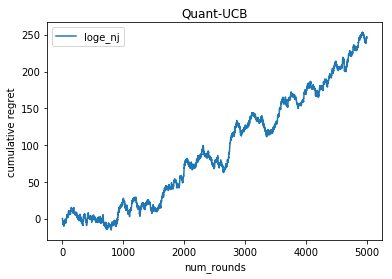

In [8]:
for key, value in Regret_dict.items():
    value = np.asarray(value)
    ave_regret = np.average(value, axis = 0)
    plt.plot(ave_regret, label = key)
    
plt.ylabel('cumulative regret')
plt.xlabel('num_rounds')
plt.title('Quant-UCB')
plt.legend()
plt.savefig('QuantUCB.png')

### UCB1

In [9]:
# compare with UCB1 algorithm

def upperBound(step, numPlays):
    ub = math.sqrt(2 * math.log(step + 1) / numPlays)
    return ub
def ucb1(num_rounds, loc, scale, alpha_skew):
    rewards = {}
    numPlays = {}
    
    # initialize empirical reward
    rewards['normal'] = np.random.normal(loc, scale, 1)[0]
    rewards['skewed'] = randn_skew(1, alpha_skew)[0]
    numPlays['normal'] = 1
    numPlays['skewed'] = 1

    # define best action as skewed arm since it has larger expected value
    cumulativeReward = 0
    bestActionCumulativeReward = 0
    Regret_list = []
    selected_action = []

    for i in range(2, num_rounds):
        if rewards['normal']/numPlays['normal'] + upperBound(i, numPlays['normal']) \
                > rewards['skewed']/numPlays['skewed'] + upperBound(i, numPlays['skewed']):
            theReward = np.random.normal(loc, scale, 1)[0]
            numPlays['normal'] += 1
            rewards['normal'] += theReward
            bestActionCumulativeReward += randn_skew(1, alpha_skew)[0]
            #bestActionCumulativeReward += theReward
            selected_action.append(1)
        else:
            theReward = randn_skew(1, alpha_skew)[0]
            numPlays['skewed'] += 1
            rewards['skewed']+= theReward
            bestActionCumulativeReward += theReward
            #bestActionCumulativeReward += np.random.normal(loc, scale, 1)[0]
            selected_action.append(2)
        cumulativeReward += theReward
        regret = bestActionCumulativeReward - cumulativeReward
        Regret_list.append(regret)

    return Regret_list, selected_action 

#Regret_list = ucb1(num_rounds, loc, scale, alpha_skew)

In [10]:
Regret_list = []
num_exper = 10
for exper in range(num_exper):
    for i, level in enumerate(level_list):
        regret, selected_action = ucb1(num_rounds, loc, scale, alpha_skew)
        Regret_list.append(regret)
        #print(selected_action)
        #Regret_list = quant_ucb(num_rounds, loc, scale, alpha_skew, level)
    
regret = np.asarray(Regret_list)
ave_regret = np.average(regret, axis = 0)
#plt.plot(ave_regret)


/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


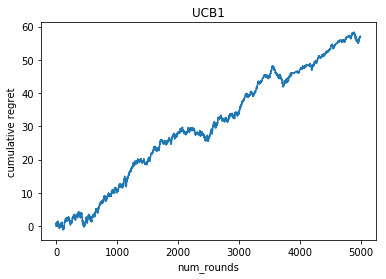

In [11]:
plt.plot(ave_regret)
plt.ylabel('cumulative regret')
plt.xlabel('num_rounds')
plt.title('UCB1')
    
plt.legend()
plt.savefig('UCB1.png')